## Demonstration on the usage of MCTS library

Using a Greedy predictor

In [1]:
# import libraries
from MCTS.utils import *
from MCTS.Agent import *
from MCTS.MCTS import *

In [2]:
%matplotlib inline

### Import Game Rule

In [3]:
import rules.Othello as Othello
OthelloGame   = Othello.OthelloGame   # shorthand
OthelloHelper = Othello.OthelloHelper # shorthand

### Import Data Structure

In [4]:
class OthelloDataNode(GameDataNode):
    def __init__(self, name, Game=OthelloGame, player=1):
        super().__init__(Game=Game, name=name, player=player)
    # end def

    def str_encode(self):
        '''encode into a string representation'''
        temp = []
        for state in self.state:
            data_str = ' '.join(shlex.split(str(state.data)))
            temp.append(str({'data': data_str, 'player': self.player}))
        # end for
        return hashlib.md5(str(temp).encode()).hexdigest()
    # end def
# end class

### Import and Inherit Agent class

In [5]:
# import agent class here
from MCTS.Agent import Agent
class OthelloAgent(Agent):
    def __init__(self, predictor):
        super(OthelloAgent, self).__init__(
            Game = OthelloGame,
            predictor = predictor
        ) # end super
    # end def
# end class

### Simulation parameter setting

In [6]:
state_memory_n = 3
tree_depth   = 3
allowed_time = 10

#### Define intial state of the game to simulate

In [7]:
new_board = OthelloHelper.new_board()
init_state = [stateType(data=new_board, player=1) for _ in range(state_memory_n)]

In [8]:
# show the initial state
init_state[-1].data, init_state[-1].player

(array([[ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0, -1,  1,  0,  0,  0],
        [ 0,  0,  0,  1, -1,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0]]), 1)

### Instantiate agent with a Greedy predictor

#### Define a predictor class
A predictor object must provide a "get" method that takes in game's state and return a list of ranked action

In [9]:
# Define a Greedy predictor here
class GreedyPredictor:
    def __init__(self, Game, rand_factor=0.3):
        self.Game = Game
        self.rand_factor = rand_factor
    # end def

    def get(self, state):
        nexts = self.Game.list_nexts(state)
        if len(nexts) > 1:
            # random 
            if random.random() < self.rand_factor:
                return random.choice(nexts).action
            # end if

            # greedy
            sorter = []
            for item in nexts:
                value = sum(item.state[-1].data.flatten())
                value = value*state[-1].player
                sorter.append([value, random.random(), item.action])
            # end for
            sorter.sort()
            return sorter[-1][-1]
        else:
            return nexts[0].action
        # end if
    # end def
# end class

#### Instantiate an agent using the greedy predictor

In [10]:
greedy_predictor = GreedyPredictor(OthelloGame)
greedy_agent = Agent(OthelloGame, greedy_predictor)

(note: materials below are the same as previous demo)

###  Run a playout with the greedy agent
(note: a playout does not involve MCTS)

In [11]:
output = greedy_agent.playout(
    init_state, 
    max_steps=70, 
    legal_action_check=True, 
    legal_action_max_trials=100
)

In [12]:
output

{'winner': -1, 'record': <MCTS.utils.GameRecord at 0x7fc2c8e31f60>}

#### Print the outcome

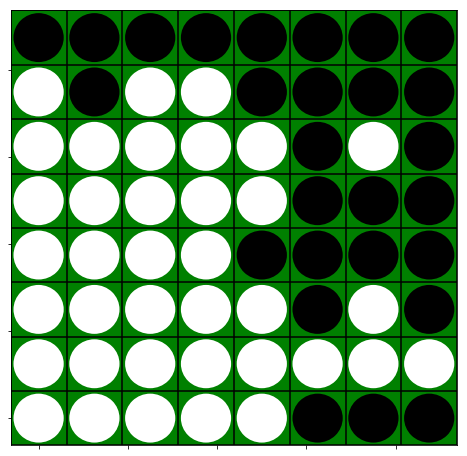

In [13]:
final_state = output['record'].state_trace[-1][-1]
OthelloHelper.print_board(final_state)

### Define a MCTS Runner

In [15]:
runner = MCTS_Runner(OthelloDataNode, agent=greedy_agent)

#### Set the initial state

In [16]:
runner.set_state(init_state)

#### Provide the prior node 

In [17]:
# note: there is no prior node here, so we set it to None
prior_node = None

#### Actually start sampling

In [18]:
sampled_node = runner.start_mcts(
  tree_depth=tree_depth, 
  allowed_time=allowed_time,
  prior_node=prior_node
) # end start

In [17]:
print(sampled_node.print_tree())

-root: 126/260
 -(2, 3): 4/23
  -(2, 2): 4/6
   -(2, 1): 0/2
   -(3, 2): 0/1
   -(4, 5): 1/2
   -(5, 4): 0/1
  -(2, 4): 9/10
   -(1, 5): 0/2
   -(2, 5): 0/2
   -(3, 5): 0/2
   -(4, 5): 1/2
   -(5, 5): 0/2
  -(4, 2): 5/7
   -(5, 1): 0/1
   -(5, 2): 0/1
   -(5, 3): 1/2
   -(5, 4): 1/2
   -(5, 5): 0/1
 -(3, 2): 50/92
  -(2, 2): 9/25
   -(1, 2): 3/5
   -(2, 3): 2/5
   -(4, 5): 4/6
   -(5, 4): 7/9
  -(2, 4): 20/39
   -(1, 5): 2/6
   -(2, 5): 1/5
   -(3, 5): 2/6
   -(4, 5): 8/13
   -(5, 5): 4/9
  -(4, 2): 11/28
   -(5, 1): 3/5
   -(5, 2): 4/6
   -(5, 3): 4/6
   -(5, 4): 4/6
   -(5, 5): 2/5
 -(4, 5): 27/60
  -(3, 5): 18/29
   -(2, 2): 2/6
   -(2, 3): 1/5
   -(2, 4): 1/4
   -(2, 5): 2/6
   -(2, 6): 4/8
  -(5, 3): 7/16
   -(2, 2): 2/3
   -(3, 2): 1/3
   -(4, 2): 1/3
   -(5, 2): 3/4
   -(6, 2): 1/3
  -(5, 5): 6/15
   -(2, 3): 0/2
   -(3, 2): 3/4
   -(5, 4): 4/5
   -(6, 5): 2/4
 -(5, 4): 44/85
  -(3, 5): 17/34
   -(2, 2): 7/10
   -(2, 3): 2/6
   -(2, 4): 1/5
   -(2, 5): 4/8
   -(2, 6): 1/5
  -(5,

### Choose a node using the tree search result

In [18]:
chosen_node = runner.choose_node(sampled_node.children)

#### Print the action selected

In [19]:
chosen_node.action

(3, 2)